# ドル円為替レート 日足

In [10]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = 'USDJPY=X'
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='2y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-11-07 00:00:00+00:00,138.794998,138.800003,138.789993,138.800003,0,0.0,0.0
2022-11-14 00:00:00+00:00,139.552994,140.768997,137.809006,140.339996,0,0.0,0.0
2022-11-21 00:00:00+00:00,140.253006,142.238998,138.095001,139.119995,0,0.0,0.0
2022-11-28 00:00:00+00:00,139.309998,139.882996,133.673004,134.309998,0,0.0,0.0
2022-12-05 00:00:00+00:00,134.475006,137.837997,134.134003,136.580002,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-14 00:00:00+01:00,149.334000,150.139008,148.852997,149.520004,0,0.0,0.0
2024-10-21 00:00:00+01:00,149.600006,153.164993,149.095993,152.279999,0,0.0,0.0
2024-10-28 00:00:00+00:00,152.951996,153.867996,151.835007,153.009995,0,0.0,0.0


## パラボリック SAR

In [11]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

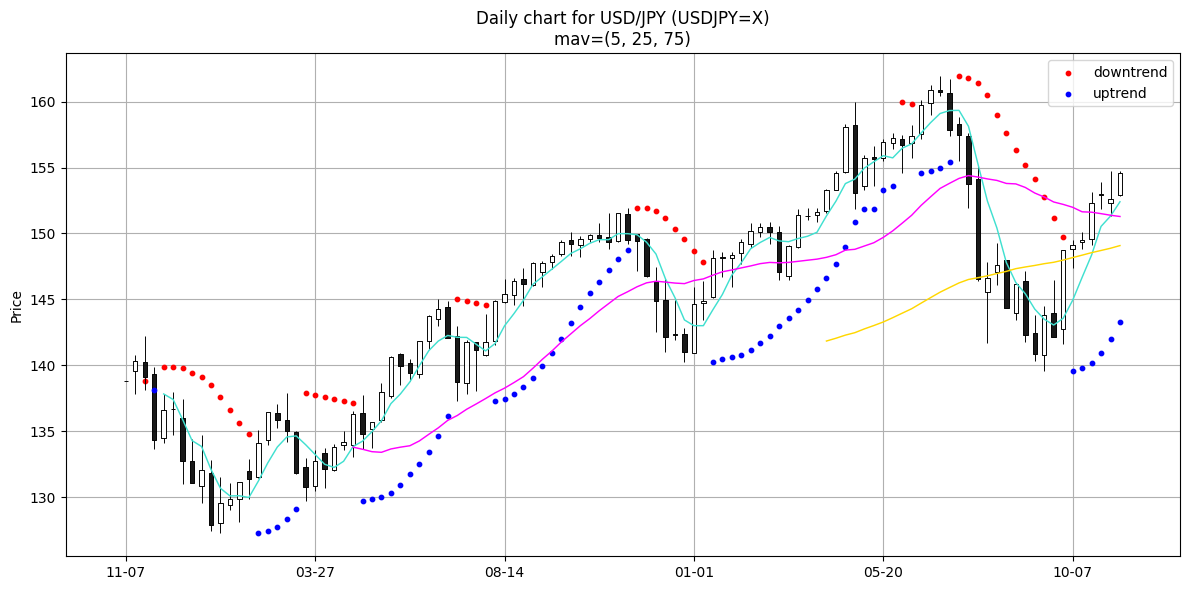

In [12]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('weekly_chart_exchange_psar.png')
plt.show()

In [8]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-11 00:00:00+00:00,152.904007,154.759995,152.869995,154.533997,0,0.0,0.0


In [9]:
df.tail(2)['Close']

Date
2024-11-04 00:00:00+00:00    152.639999
2024-11-11 00:00:00+00:00    154.533997
Name: Close, dtype: float64

In [10]:
df.tail(2)['Close'].diff()

Date
2024-10-28 00:00:00+00:00         NaN
2024-11-04 00:00:00+00:00   -0.389999
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).mean().tail(5)

Date
2024-10-07 00:00:00+01:00    152.088077
2024-10-14 00:00:00+01:00    151.891923
2024-10-21 00:00:00+01:00    151.668462
2024-10-28 00:00:00+00:00    151.667308
2024-11-04 00:00:00+00:00    151.546539
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).mean().tail(5)

Date
2024-10-07 00:00:00+01:00    150.171346
2024-10-14 00:00:00+01:00    150.165000
2024-10-21 00:00:00+01:00    150.215442
2024-10-28 00:00:00+00:00    150.285538
2024-11-04 00:00:00+00:00    150.306692
Name: Close, dtype: float64